First I want to import libraries. I also downloaded the data from kaggle.

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import networkx as nx

[nltk_data] Downloading package stopwords to C:\Users\Emil
[nltk_data]     Łasocha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# file_path = "arxiv-metadata-oai-snapshot.json"
# df = pd.read_json(file_path, lines=True)
# print(df.head())

I waited about 10 minutes in order to open this file. Unfortunately, it could not load into dataframe. We will see how many lines are there in this file.

In [4]:
input_file = "arxiv-metadata-oai-snapshot.json"
line_count = 0
with open(input_file, "r") as file:
    for line in file:
        line_count += 1

print(f"Total number of lines in the file: {line_count}")

Total number of lines in the file: 2647472


We will consider the first 1% of our file.

In [5]:
all_lines = line_count//100 + 1
print(all_lines)

data = []
with open(input_file, "r") as file:
    for i in range(all_lines):
        line = file.readline()
        data.append(json.loads(line.strip()))
df = pd.DataFrame(data)

print(f"There are {len(df)} records in the df DataFrame.")
print(df.head())

26475
There are 26475 records in the df DataFrame.
          id           submitter  \
0  0704.0001      Pavel Nadolsky   
1  0704.0002        Louis Theran   
2  0704.0003         Hongjun Pan   
3  0704.0004        David Callan   
4  0704.0005  Alberto Torchinsky   

                                             authors  \
0  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...   
1                    Ileana Streinu and Louis Theran   
2                                        Hongjun Pan   
3                                       David Callan   
4           Wael Abu-Shammala and Alberto Torchinsky   

                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2  The evolution of the Earth-Moon system based o...   
3  A determinant of Stirling cycle numbers counts...   
4  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                  comments  \
0  37 pages,

And check the columns. Also prepare a data frame with only necessary columns.

In [6]:
print(df.columns)

Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'],
      dtype='object')


In [7]:
df1 = df[["id", "categories", "abstract"]]
print(df1.head())

          id       categories  \
0  0704.0001           hep-ph   
1  0704.0002    math.CO cs.CG   
2  0704.0003   physics.gen-ph   
3  0704.0004          math.CO   
4  0704.0005  math.CA math.FA   

                                            abstract  
0    A fully differential calculation in perturba...  
1    We describe a new algorithm, the $(k,\ell)$-...  
2    The evolution of Earth-Moon system is descri...  
3    We show that a determinant of Stirling cycle...  
4    In this paper we show how to compute the $\L...  


# ---TASK 1---
## Task 1.1

Let's check what are the record names' of categories. 

In [8]:
print(df1.iloc[:80, 1])

0              hep-ph
1       math.CO cs.CG
2      physics.gen-ph
3             math.CO
4     math.CA math.FA
           ...       
75      hep-ph hep-ex
76     physics.gen-ph
77              gr-qc
78            math.OA
79           astro-ph
Name: categories, Length: 80, dtype: object


We see that for arbitrary paper there could be more than one category. They are separated by a space. We also want the first bit before "." and "-" characters. We will count the number of them by creating a set. If the category has never been added to a set, it will be added with default value of 0, and we will add 1. If the category exists, it will get the current numbers of it, and then add 1.

In [9]:
different_categories = {}

for category in df1.categories:
    for word in category.split():
        word1 = word.split(".")[0].split("-")[0]
        different_categories[word1] = different_categories.get(word1, 0) + 1

print(different_categories)

{'hep': 5937, 'math': 10745, 'cs': 1711, 'physics': 2805, 'cond': 6999, 'gr': 1458, 'astro': 5404, 'nlin': 583, 'q': 783, 'quant': 1740, 'nucl': 1074, 'stat': 499, 'econ': 3}


Now we will prepare a bar plot out of these data.

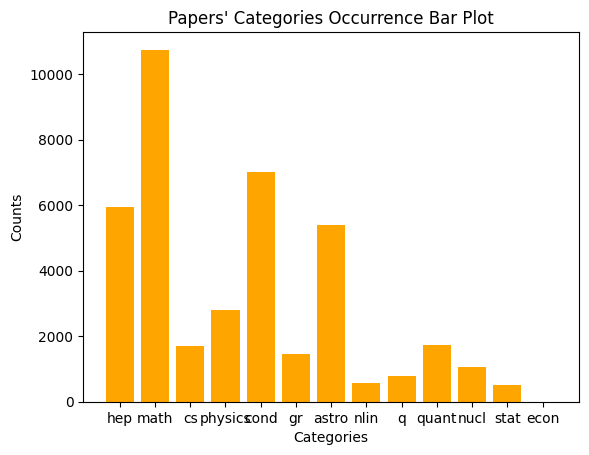

In [10]:
elements = list(different_categories.keys())
counts = list(different_categories.values())

plt.bar(elements, counts, color="orange")

plt.xlabel("Categories")
plt.ylabel("Counts")
plt.title("Papers' Categories Occurrence Bar Plot")

plt.show()

## Task 1.2

We will consider only the papers from math category and the column "abstract".

In [11]:
category_abstracts = df1[df1["categories"].str.contains("math")]["abstract"]
print(category_abstracts.head())

1       We describe a new algorithm, the $(k,\ell)$-...
3       We show that a determinant of Stirling cycle...
4       In this paper we show how to compute the $\L...
9       Partial cubes are isometric subgraphs of hyp...
10      In this paper we present an algorithm for co...
Name: abstract, dtype: object


And we will make this as a string variable.

In [12]:
text = " ".join(category_abstracts)
print(type(text))
print(text[1001:2000])

<class 'str'>
rsing involution to evaluate the
determinant.
   In this paper we show how to compute the $\Lambda_{\alpha}$ norm, $\alpha\ge
0$, using the dyadic grid. This result is a consequence of the description of
the Hardy spaces $H^p(R^N)$ in terms of dyadic and special atoms.
   Partial cubes are isometric subgraphs of hypercubes. Structures on a graph
defined by means of semicubes, and Djokovi\'{c}'s and Winkler's relations play
an important role in the theory of partial cubes. These structures are employed
in the paper to characterize bipartite graphs and partial cubes of arbitrary
dimension. New characterizations are established and new proofs of some known
results are given.
  The operations of Cartesian product and pasting, and expansion and
contraction processes are utilized in the paper to construct new partial cubes
from old ones. In particular, the isometric and lattice dimensions of finite
partial cubes obtained by means of these operations are calculated.
   In this p

We will do some cleaning. The cleaning function will first convert all words to lower-case. Then we will replace any sequence of numbers with a space. And then we will also replace any non-word character with a blank space. Then we will remove stop words.

In [13]:
def cleaning(sample_text):  
    
    sample_text = sample_text.lower()
    sample_text = re.sub(r"\d+", " ", sample_text)
    sample_text = re.sub(r"\W+", " ", sample_text)
    
    stop_words = set(stopwords.words("english"))
    cleaned_text = " ".join([wrd for wrd in sample_text.split() if wrd not in stop_words])

    return cleaned_text

Let's test it.

In [14]:
text = cleaning(text)
print(text[:1000])

describe new algorithm k ell pebble game colors use obtain characterization family k ell sparse graphs algorithmic solutions family problems concerning tree decompositions graphs special instances sparse graphs appear rigidity theory received increased attention recent years particular colored pebbles generalize strengthen previous results lee streinu give new proof tutte nash williams characterization arboricity also present new decomposition certifies sparsity based k ell pebble game colors work also exposes connections pebble game algorithms previous sparse graph algorithms gabow gabow westermann hendrickson show determinant stirling cycle numbers counts unlabeled acyclic single source automata proof involves bijection automata certain marked lattice paths sign reversing involution evaluate determinant paper show compute lambda_ alpha norm alpha ge using dyadic grid result consequence description hardy spaces h p r n terms dyadic special atoms partial cubes isometric subgraphs hyper

Now we will prepare a wordcloud.

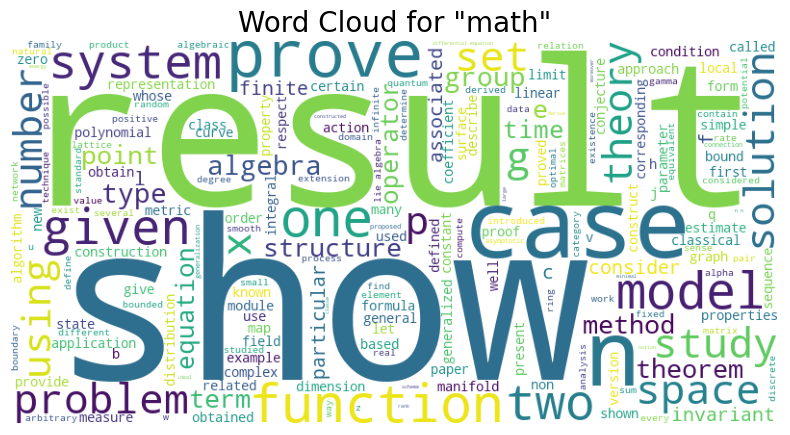

In [15]:
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title(f'Word Cloud for "math"', fontsize=20)
plt.show()

Amazing.

## Task 1.3

Firstly, let's find 5 most common categories.

In [16]:
most_common = sorted(different_categories, key=different_categories.get, reverse=True)[:5]
print(most_common)

['math', 'cond', 'hep', 'astro', 'physics']


We will create a function. We consider a set "word_frequencies" and do similar trick as previously. Then we will sort it by the values in descending order. And take the first three tuples ("key", "word").

In [17]:
def top3_word_count(sample_text):
    words = sample_text.split()
    word_frequencies = {}
    for single_word in words:
        word_frequencies[single_word] = word_frequencies.get(single_word, 0) + 1
    most_common_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:3]
    return most_common_words

For each of the 5 most common categories we will take the records containing its word in "categories" section. And we will change the abstracts to a string and do the cleaning.  

In [18]:
for ctgr in most_common:
    category_abstracts = df1[df1["categories"].str.contains(f"{ctgr}")]["abstract"]
    text = " ".join(category_abstracts)
    text = cleaning(text)
    print(f"The most common words in abstracts' of the articles from category {ctgr} are: {top3_word_count(text)}.")

The most common words in abstracts' of the articles from category math are: [('n', 3635), ('x', 2146), ('show', 2000)].
The most common words in abstracts' of the articles from category cond are: [('spin', 2717), ('two', 2271), ('model', 2156)].
The most common words in abstracts' of the articles from category hep are: [('model', 2604), ('theory', 2209), ('field', 1831)].
The most common words in abstracts' of the articles from category astro are: [('mass', 3698), ('x', 2875), ('galaxies', 2835)].
The most common words in abstracts' of the articles from category physics are: [('model', 867), ('two', 768), ('time', 762)].


# ---TASK 2---

There are two columns containing authors. We will use the column "authors_parsed", as it seems to be better with processing. 

In [19]:
df2 = df[["id", "authors_parsed", "authors"]]
print(df2.head)

<bound method NDFrame.head of               id                                     authors_parsed  \
0      0704.0001  [[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...   
1      0704.0002           [[Streinu, Ileana, ], [Theran, Louis, ]]   
2      0704.0003                                 [[Pan, Hongjun, ]]   
3      0704.0004                                [[Callan, David, ]]   
4      0704.0005  [[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]   
...          ...                                                ...   
26470  0709.4205                                   [[Levin, Yan, ]]   
26471  0709.4206  [[da Silva, Joao Paulo Muller, ], [Acencio, Ma...   
26472  0709.4207  [[Quintana-Lacaci, G., ], [Jiménez-Esteban, F....   
26473  0709.4208     [[Cogan, P., , for the VERITAS Collaboration]]   
26474  0709.4209  [[Tkacik, Gasper, ], [Callan, Curtis G, Jr], [...   

                                                 authors  
0      C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...  

We want to make a graph. In order for it to be readable, we will cover only the first 2,5% of papers (so 661 of them).  

In [20]:
lists = [df2.iloc[i,1] for i in range(len(df2)//40)]
print(lists[:10])

[[['Balázs', 'C.', ''], ['Berger', 'E. L.', ''], ['Nadolsky', 'P. M.', ''], ['Yuan', 'C. -P.', '']], [['Streinu', 'Ileana', ''], ['Theran', 'Louis', '']], [['Pan', 'Hongjun', '']], [['Callan', 'David', '']], [['Abu-Shammala', 'Wael', ''], ['Torchinsky', 'Alberto', '']], [['Pong', 'Y. H.', ''], ['Law', 'C. K.', '']], [['Corichi', 'Alejandro', ''], ['Vukasinac', 'Tatjana', ''], ['Zapata', 'Jose A.', '']], [['Swift', 'Damian C.', '']], [['Harvey', 'Paul', ''], ['Merin', 'Bruno', ''], ['Huard', 'Tracy L.', ''], ['Rebull', 'Luisa M.', ''], ['Chapman', 'Nicholas', ''], ['Evans', 'Neal J.', 'II'], ['Myers', 'Philip C.', '']], [['Ovchinnikov', 'Sergei', '']]]


We will now create the graph. We will create the function that describes the full name of the author.

In [21]:
def create_full_name(author):
    return f"{author[0]} {author[1]}"

Now let's make a graph. First we create a full_names list of authors' for each paper (and add it to the vertices of the graph G). The group_tuple variable is just a tuple of full_names of a specific paper. Then for each author we have a new entry with key of the first author and empty value. We keep track the index number of paper on which a person worked on.

In [22]:
G = nx.Graph()
collaborations = {}
index = 0

for paper in lists:
    full_names = [create_full_name(author) for author in paper]
    G.add_nodes_from(full_names)

    for author in full_names:
        if author not in collaborations:
            collaborations[author] = set()
        collaborations[author].add(index)

    index += 1

Now we add edges by iterating over the (key, value) in collaboration dictionary. We add edge only if there are at least **2 papers** on which a pair of persons worked on.

In [23]:
for author1, co_papers1 in collaborations.items():
    for author2, co_papers2 in collaborations.items():
        if author1 < author2 and len(co_papers1.intersection(co_papers2)) >= 2:
            G.add_edge(author1, author2)

We need to remove the nodes which don't have any edges.

In [24]:
nodes_with_edges = [node for node in G.nodes if G.degree(node) > 0]
G_filtered = G.subgraph(nodes_with_edges)

Now we visualize our graph! There are some additional parameters in order for the graph to look readable. With every reload, a new graph is made.

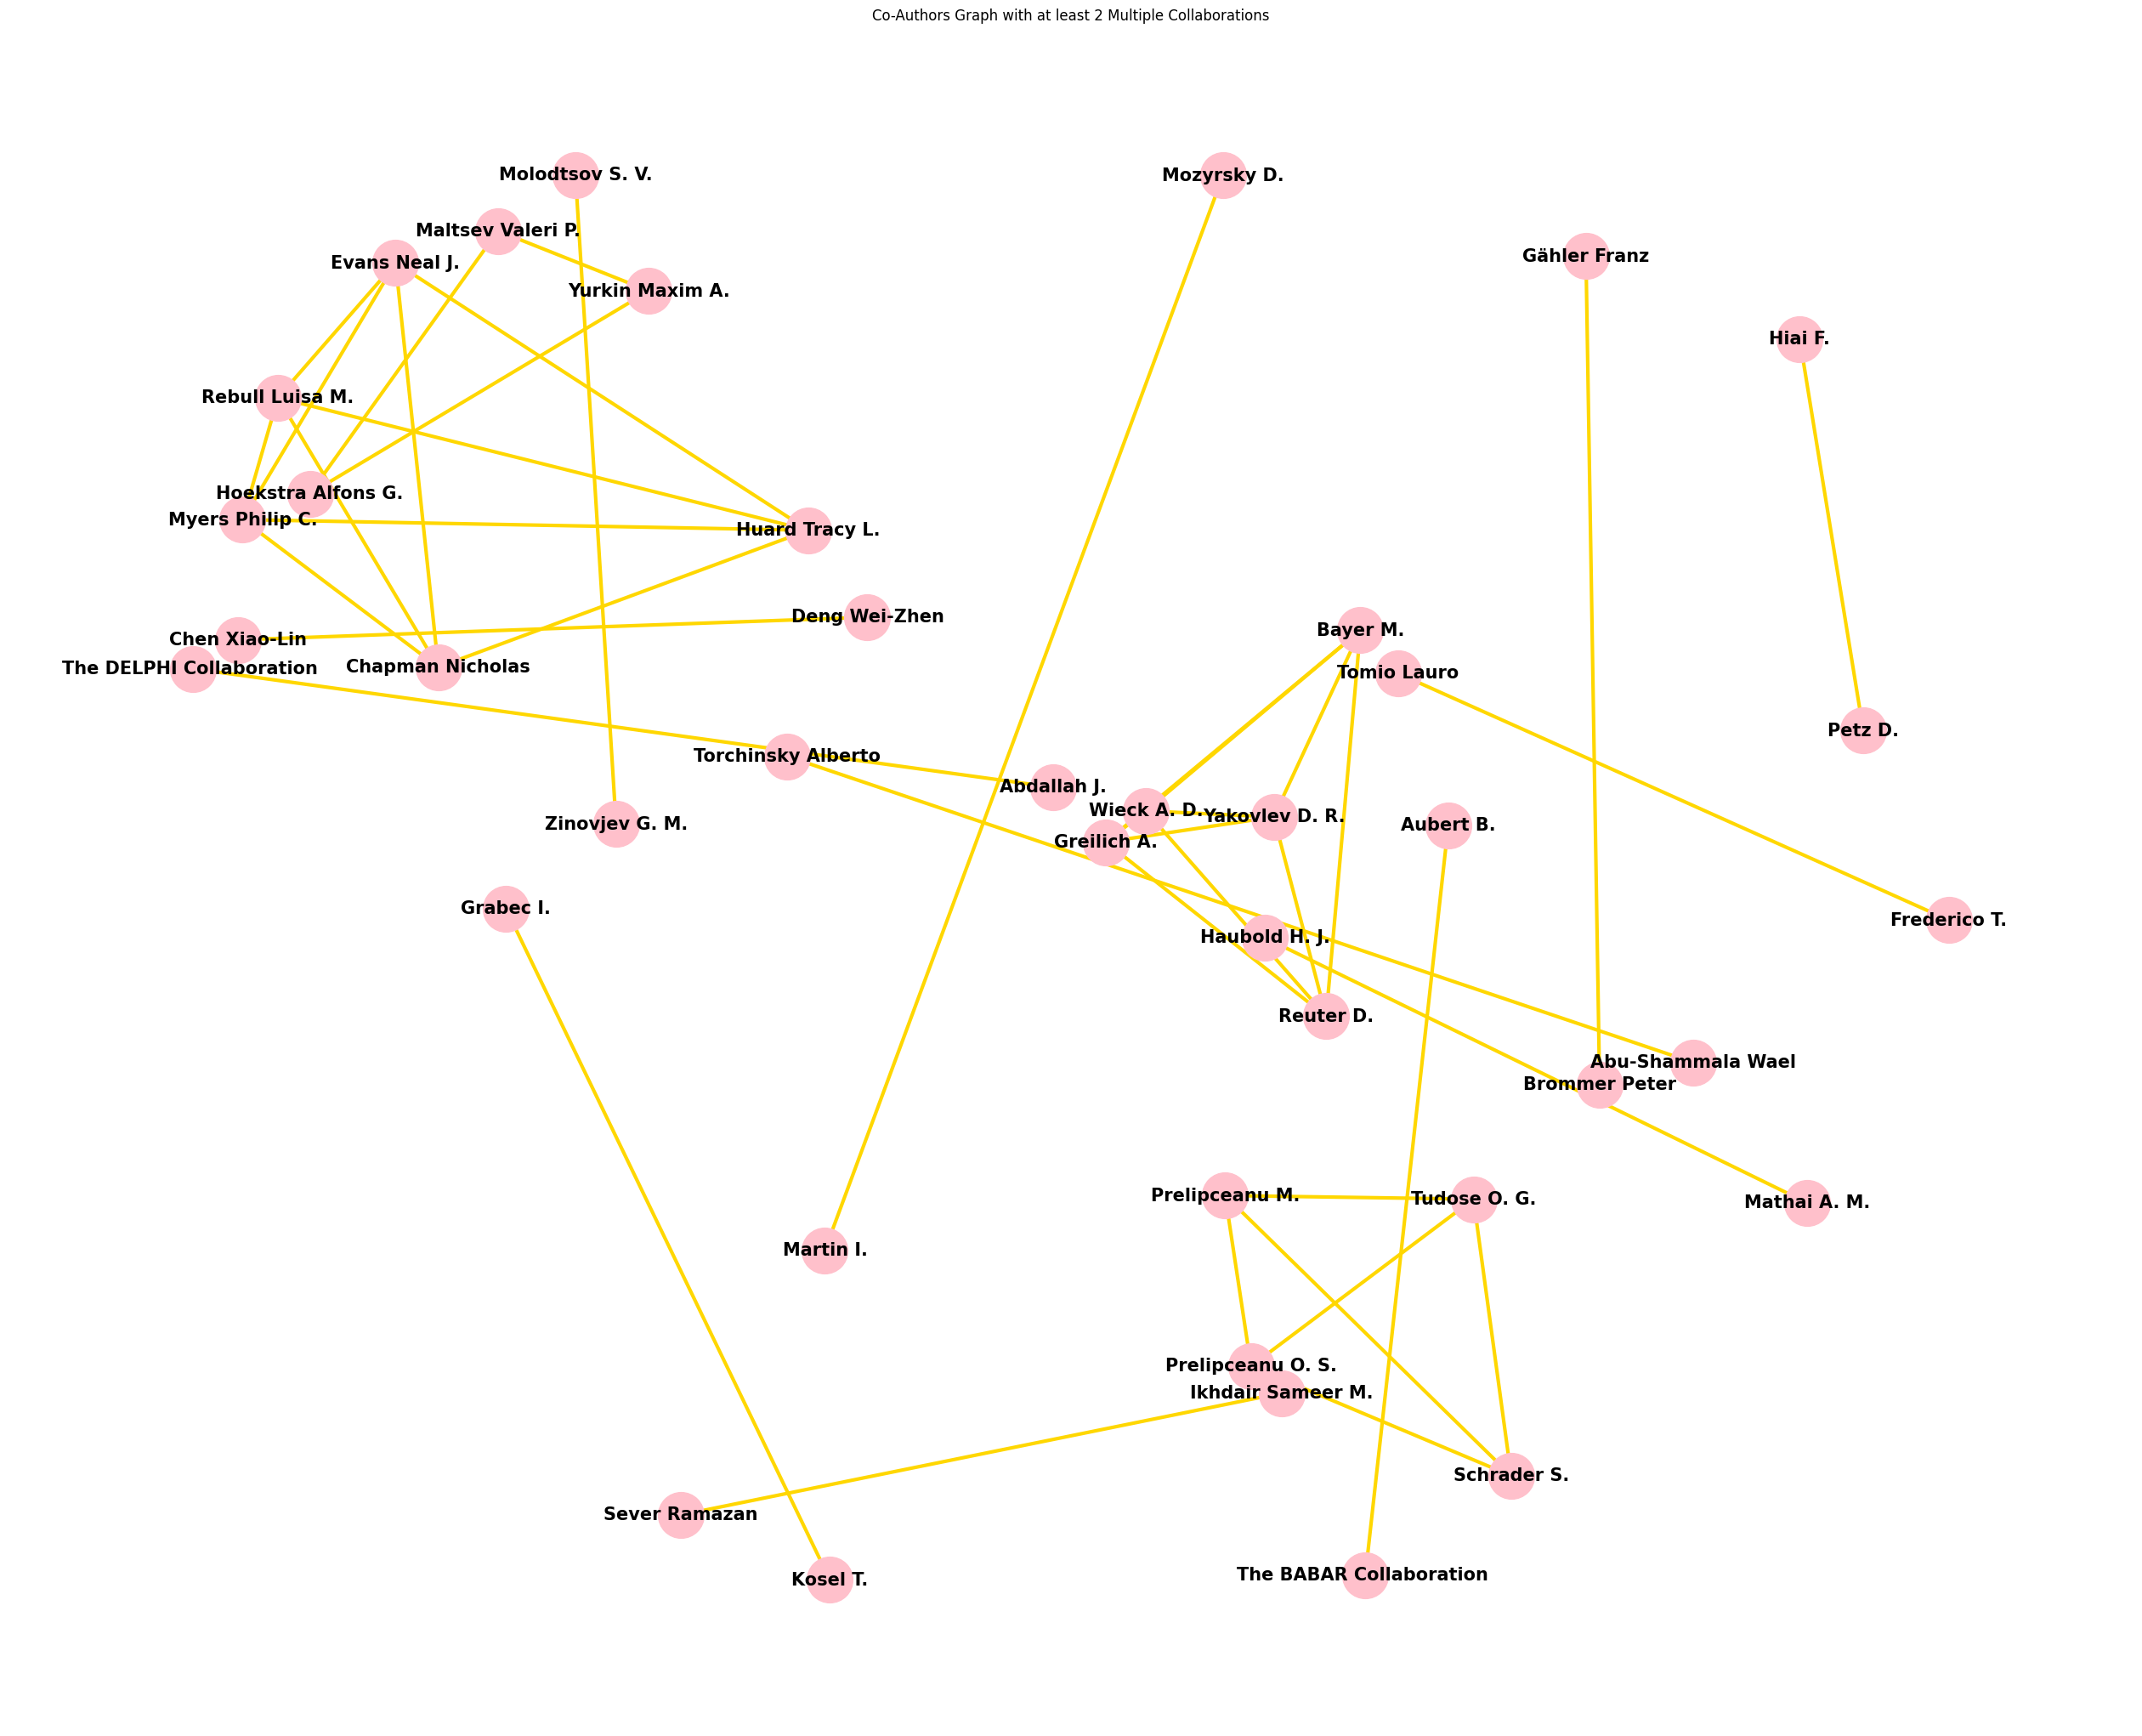

In [25]:
plt.figure(figsize=(25, 20))
pos = nx.spring_layout(G, k=0.4, iterations=60)
nx.draw(G_filtered, pos, with_labels=True, node_size=1500, node_color="pink", font_size=15, font_weight="bold", edge_color='gold', width=3)
plt.title("Co-Authors Graph with at least 2 Multiple Collaborations")
plt.show()

Lastly, let's print the authors and the connections.

In [26]:
print("Vertices in the graph:", tuple(G_filtered.nodes))

Vertices in the graph: ('Aubert B.', 'Zinovjev G. M.', 'Frederico T.', 'Reuter D.', 'Myers Philip C.', 'Huard Tracy L.', 'Mathai A. M.', 'The DELPHI Collaboration ', 'Tudose O. G.', 'Schrader S.', 'The BABAR Collaboration ', 'Gähler Franz', 'Mozyrsky D.', 'Brommer Peter', 'Maltsev Valeri P.', 'Yakovlev D. R.', 'Hiai F.', 'Greilich A.', 'Tomio Lauro', 'Abdallah J.', 'Hoekstra Alfons G.', 'Chen Xiao-Lin', 'Prelipceanu M.', 'Deng Wei-Zhen', 'Petz D.', 'Haubold H. J.', 'Bayer M.', 'Kosel T.', 'Ikhdair Sameer M.', 'Evans Neal J.', 'Grabec I.', 'Sever Ramazan', 'Yurkin Maxim A.', 'Molodtsov S. V.', 'Martin I.', 'Prelipceanu O. S.', 'Torchinsky Alberto', 'Chapman Nicholas', 'Rebull Luisa M.', 'Abu-Shammala Wael', 'Wieck A. D.')


In [27]:
print("Edges in the graph:", tuple(G_filtered.edges))

Edges in the graph: (('Aubert B.', 'The BABAR Collaboration '), ('Zinovjev G. M.', 'Molodtsov S. V.'), ('Frederico T.', 'Tomio Lauro'), ('Reuter D.', 'Greilich A.'), ('Reuter D.', 'Yakovlev D. R.'), ('Reuter D.', 'Wieck A. D.'), ('Reuter D.', 'Bayer M.'), ('Myers Philip C.', 'Huard Tracy L.'), ('Myers Philip C.', 'Chapman Nicholas'), ('Myers Philip C.', 'Evans Neal J.'), ('Myers Philip C.', 'Rebull Luisa M.'), ('Huard Tracy L.', 'Rebull Luisa M.'), ('Huard Tracy L.', 'Chapman Nicholas'), ('Huard Tracy L.', 'Evans Neal J.'), ('Mathai A. M.', 'Haubold H. J.'), ('The DELPHI Collaboration ', 'Abdallah J.'), ('Tudose O. G.', 'Prelipceanu M.'), ('Tudose O. G.', 'Prelipceanu O. S.'), ('Tudose O. G.', 'Schrader S.'), ('Schrader S.', 'Prelipceanu M.'), ('Schrader S.', 'Prelipceanu O. S.'), ('Gähler Franz', 'Brommer Peter'), ('Mozyrsky D.', 'Martin I.'), ('Maltsev Valeri P.', 'Yurkin Maxim A.'), ('Maltsev Valeri P.', 'Hoekstra Alfons G.'), ('Yakovlev D. R.', 'Greilich A.'), ('Yakovlev D. R.', 'W